# Forced Aligner

**Forced algner** is an algorithm which able to create an alignment between audio and their transcription.



Let's say you have an audio that says "*Hi, my name is Alex*", we want to get the alignment for this text.
The output of forced aligner algorithm may looks like this:
* Hi - (00:00 - 00:25)
* my - (00:25 - 0.44)
* name - (00:44 - 0:95)
* Alex - (0:95 - 1:15)

It is nothing more than a transcription with timestamps for each word. Forced alignment may be aplied on different levels, such is: phonemes, words, sentences. Which means if you align a phonemes, you got a timestamp for each phoemes and so on.


## Where it's may be used for?

There are a lot of usecases for forced aligner. The basic one is a subtitles alignment with a video/audio. Lyrics sync with a music.
It's may be used in data preprocessing stage, for example if you want to split audio by sentences, you should to use forced aligner.


## Is there any ready to use forced aligner?

Yes. If you want to use forced alifner in the real-job i recommend you check [Montreal Forced Aligner](https://montreal-forced-aligner.readthedocs.io/en/latest/user_guide/commands.html). This is one of the best aligners in the opensource. MFA uses tricky algorithms based on Hidden-Markov-Model (HMM), which still outperform neural models in alignment task.


## What this article about?
I will no explain how to use MFA because you can check the MFA Doc for that. Also I will not talk about how MFA works, because MFA uses complicated and tricky algorithms which is hard to understand. Instead of that we will implement our own simple forced aligner to understand what is in underhood of forced aligners.

In [1]:
# Don't worry, these are just dependencies that will be used later.

!apt install espeak-ng

import IPython
from IPython.display import Audio
import librosa
import numpy as np
import subprocess
import librosa.display
from subprocess import Popen, PIPE, STDOUT
from io import BytesIO
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,525 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 espeak-ng-data amd64 1.50+dfsg-10 [3,956 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libespeak-ng1 amd64 1.50+dfsg-10 [207 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak-ng amd64 1.50+dfsg-10 [343 kB]
Fetched 4,525 kB in 3s (1,793 k

## The task

So lets define the task:

We have a list of sentences - `sentences`. And the audio `audio.wav` which contains a pronounce of this sentences.
We want to get per-sentence alignment, which means a get a timestamps of every sentence in the list.

---
P.S. [Link](https://drive.google.com/file/d/1Xwys5hqma-JOVAA_sYbxLldacHj52Q-_/view?usp=sharing) to audio download.

In [2]:
sentences = [
 'the ladies.',
 'on this adventure he was about the business of young robin rue.',
 "they give him the flower from the hair of the emperor's daughter, and sing-.",
 'the wandering singer.',
 'but if time is still to spare, the second part of the game is played like this.',
 "the emperor's daughter.",
 'the singer then drops a second flower into the lap of the child in the middle, and goes away, and this ends the first part of the game.',
 "the emperor's daughter is not yet released, for the key of her tower is understood to be still in the keeping of the dancing children.",
 'forgotten, too, the name of gillian, the lovely captive.'
]


AUDIO_NAME = "concat4.wav"

Tap to listen audio:

In [3]:
Audio(AUDIO_NAME)

## The algorithm

To solve this task we will use algorthim which names **Dynamic-Time-Warping**.

Let's imagine that in addition to the input audio, we also have separate recorded audio for each sentence. These audios are recorded by a different speaker, but the exact same thing is said.

So, we may to concat this audios into the single one. It's will be simmilar to the "input audio", but pronounced by another speaker. However, it's important to note, since we've been merging this audio into one, that for this "concated audio", we'll know the start and end timestamps of each sentence.

If we able to match every frame of the "input audio" to "concated audio", we will able to transform sentence timestemps from "concated" to "input" audio. To the better understand, you can look at this image.


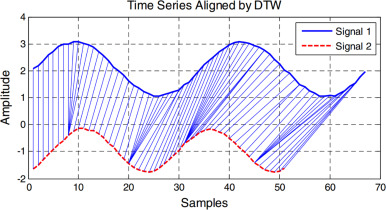

## Implementation

The basic idea is simple. But we are still have at least two questions:
* Where to get per-sentence audio?
* How to match audio-frames?

### Speech synthesis
Probably you are already fammiliar with a speech synthesis, and saw them in different applications such is voice assistans, translate app and so on.

We will use speech synthesis to generate audio for each sentence. But in this tutorial i will no use any neural method to simplify solution.

For speech generation im using **espeak** - open-source fast conctenative speech syntheser. It does not have a best audio quality and sounds so robotic, but we does not need a perfect audio quality for this task. The main advantage of espeak, that it is not need much hardvare resources and able to work fast on simple 1-core CPU.

However you can try different speech synthesers if you want.


#### Espeak techincal details
Espeak is a command line tool. Which means, that you can communicate with them using terminal and STDIN/STDOUT. Im using a subrpocessed library to call espeak and get raw-byte output directly from STDOUT, the output is a wavfile writen in bytes.

Ofcourse you can use C-Like API interface and directly call espeak methods without separate process calling, but it will be harder to implement. So this is quick and dirty solution.

In [4]:
def espeak_generate(text: str) -> np.ndarray:
    espeak_process = Popen(["espeak-ng", "--stdin", "--stdout"], stdout=PIPE, stdin=PIPE, stderr=PIPE)
    audio_data = espeak_process.communicate(input=text.encode())[0]
    espeak_process.wait()

    audio_file = BytesIO(audio_data)
    audio, sr = librosa.load(audio_file)
    audio_file.close()

    return audio, sr

🤖 Generated audio

In [5]:
_text = """
Hello, i am espeak generator. I will generate audio which we can use to dynamic time warping with original audio.
This allows us to find the best path in distance matrix, which called alignment.
"""

audio, sr = espeak_generate(_text)
Audio(data=audio, rate=sr)

Lets generate audio for each samples.

In [6]:
generated_audios = []

for text in sentences:
    audio, sr = espeak_generate(text)
    generated_audios.append(audio)

In [7]:
Audio(data=generated_audios[0], rate=sr)

In [8]:
len(generated_audios)

9

In [9]:
original_audio, sr = librosa.load(AUDIO_NAME)

In [10]:
Audio(data=original_audio, rate=sr)

## Audio matching

So, we have audio recordings, and we have to somehow match them.

Actually we can just build an NxM matrix, where each cell will contain difference between each `i` and `j` frame of the audio. But there are some limitations.

The first of all dimension sizes:

In [11]:
N = original_audio.shape[0]
M = sum([audio.shape[0] for audio in generated_audios])

print("N =", N)
print("M =", M)
print("NxM =", N*M)

N = 728312
M = 701663
NxM = 511029582856


In [12]:
(511800865264 * 32) / 8 / 1024 / 1024 / 1024 / 1024

1.8619207012816332

That is very huge sizes of data, which is hard to process, we will need at least 2 TB RAM to store this matrix. And probably few years to calculate (one-core CPU).

So google collab still has no quantum computers with 2TB RAM, that means we need to find other solution.

The second problem, that each frame of audio is just an float number, difference between two float numbers in signal is not such informative. We should to use some feature extractor before.

## MFCC

I hope that you already familiar with [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). If you no, it's will be hard to understand next parts. I recommend [this video](https://www.youtube.com/watch?v=4_SH2nfbQZ8) to understand wht is it.

MFCC is a great tool for feature extraction. Thats are using in a long time for speech recongition, because MFCC allow you to get spectrograms that are well suited for the task of audio recognition. Since they contain a lot of information that allows you to identify phonemes, but at the same time abstract from unnecessary noise or unnecessary voice characteristics. In other words, the MFCC is good at extracting phonemes from the input sound, and this is exactly what we need.

In [14]:
# librosa.feature.mfcc?

In [15]:
generated_mfcc = []

for audio in generated_audios:
    mfcc = librosa.feature.mfcc(y=audio, n_mfcc=50)
    generated_mfcc.append(mfcc)

Some MFCC visualisation

In [16]:
len(generated_mfcc)

9

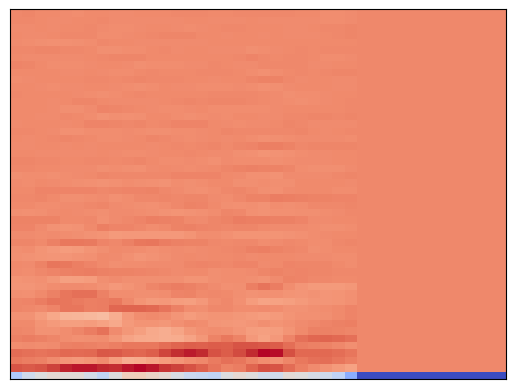

In [17]:
librosa.display.specshow(generated_mfcc[0])

In [20]:
original_mfcc = librosa.feature.mfcc(y=original_audio, n_mfcc=50)

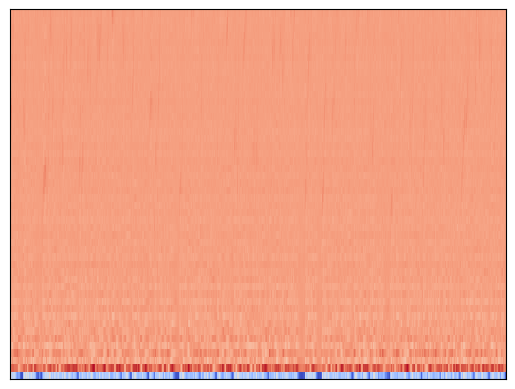

In [21]:
librosa.display.specshow(original_mfcc)

Lets concat generated MFCC matrices

In [22]:
mfcc_a = np.concatenate(generated_mfcc, axis=1)
mfcc_b = original_mfcc

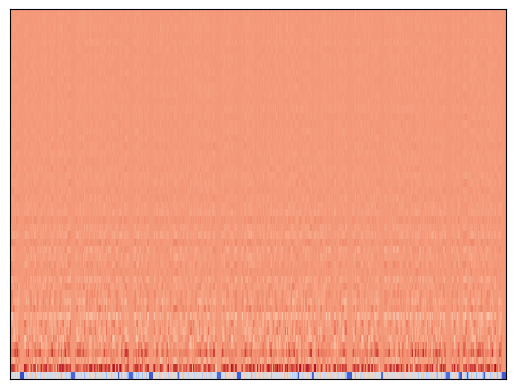

In [23]:
librosa.display.specshow(mfcc_a)

In [24]:
mfcc_a.shape

(50, 1375)

In [25]:
mfcc_b.shape

(50, 1423)

## Distance metric

So we have a two spectrocrams we should some-how somehow to mesure distance between two mfcc frames. We need to use some distance metric.

**Cosine Similarity** is widely used in MFCC pattern matching task. You can find a lot of papers about that. I will use them as a distance metric. But feel free to experiments.

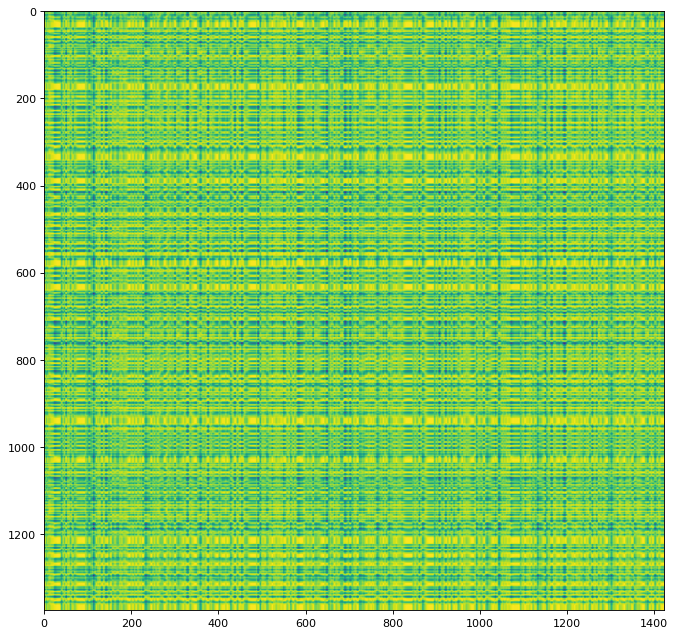

In [26]:
plt.figure(figsize=(10, 10), dpi=80)
distances = cosine_similarity(mfcc_a.T, mfcc_b.T)
plt.imshow(distances)

## Finding the solution

We got an distance matrix, which contains a distances between every frames in two MFCC. We should to use this matrix to the able match frames between each other.

You may expect that we may just select minimum distance for each frame in some axis, and our task will be done.

But that is not actually a true.

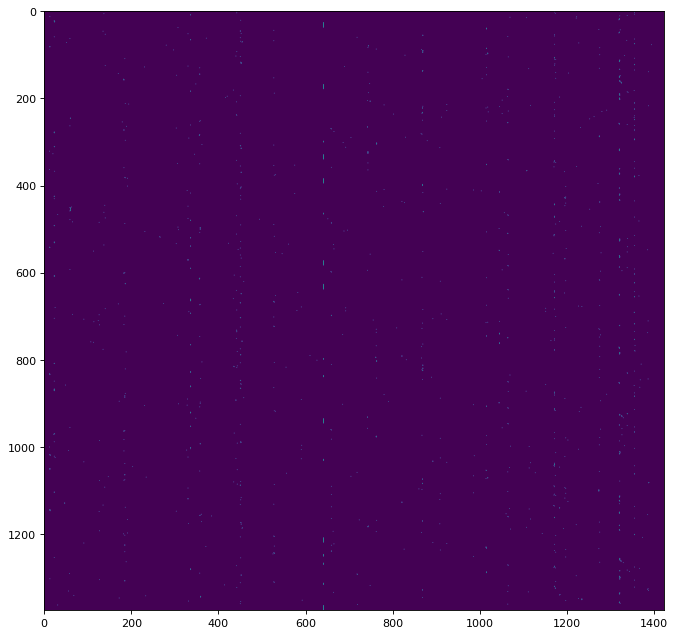

In [27]:
algnment_path = np.zeros_like(distances)
for i, j in enumerate(distances.argmax(1)):
    algnment_path[i][j] = 1000

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(algnment_path)

The real alignment has two constrains:
* Alignment - continuously. This means that if you draw a mapping matrix, you will get one continuous line.
* The alignment is monotonical all the time, which means that: if `a[i]` matches to `b[j]`, then `a[i+1]` will be never match with a `a[j-1], a[j-2] ...` . In another words, you can make time back.
* You have alignment for every frame in the sequence


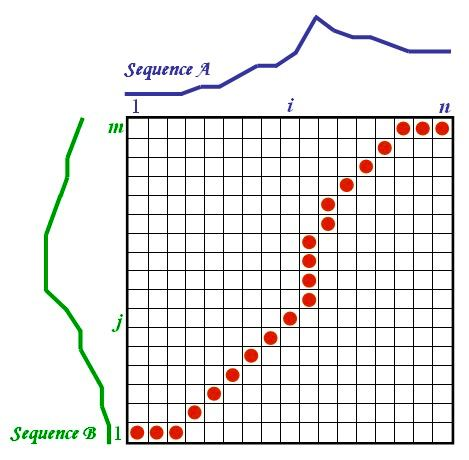


## Dynamic programming
So, the task looks pretty simmilar to an dynamic-programming task on Leetcode.
We may use this constrains to build `dp` matrix and find the answer.
Since our answer is not the length of the shortest path in the matrix, but the path itself, we must also store it in the `dp` matrix for further backtrace.


In [28]:
dp = np.ones((distances.shape[0], distances.shape[1], 3)) * np.inf
dp[0][0][0] = 0
dp[0][0][1] = -1
dp[0][0][2] = -1


for i in tqdm(range(distances.shape[0])):
    for j in range(distances.shape[1]):
        if i > 0:
            d = dp[i-1][j][0] + distances[i][j]
            if dp[i][j][0] > d:
                dp[i][j][0] = d
                dp[i][j][1] = i - 1
                dp[i][j][2] = j

        if j > 0:
            d = dp[i][j-1][0] + distances[i][j]
            if dp[i][j][0] > d:
                dp[i][j][0] = d
                dp[i][j][1] = i
                dp[i][j][2] = j - 1

        if j > 0 and i > 1:
            d = dp[i-1][j-1][0] + distances[i][j]
            if dp[i][j][0] > d:
                dp[i][j][0] = d
                dp[i][j][1] = i - 1
                dp[i][j][2] = j - 1

100%|██████████| 1375/1375 [00:19<00:00, 69.77it/s]


Lets backtrace the path

In [29]:
path = []

element = dp[-1][-1]

while int(element[1]) != -1 and int(element[2]) != -1:
    i = int(element[1])
    j = int(element[2])

    path.append((i, j))
    element = dp[i][j]

In [30]:
len(path)

1437

And draw it!

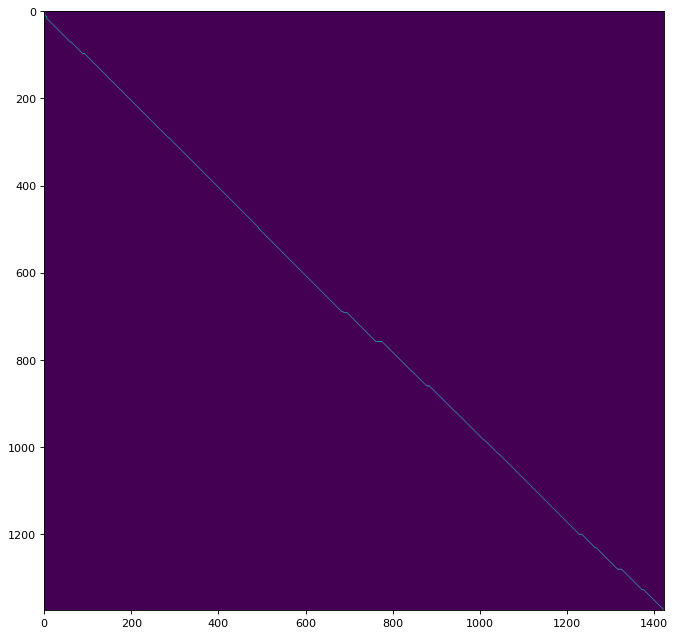

In [31]:
path_draw = np.zeros_like(distances)

for (i, j) in path:
    path_draw[i][j] = 1

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(path_draw)

Looks exactly what we wants


## Matching the timestamps

So the first of all we should know the timestamps in the MFFC coordinates of every sentence in the conncated MFCC. To do that Im using cummulative sum of lenghts of per-sentence MFCCs.


We can draw this timestamps by red lines. Now the cross between red line and aignment line - is the translation point to the another sequence.

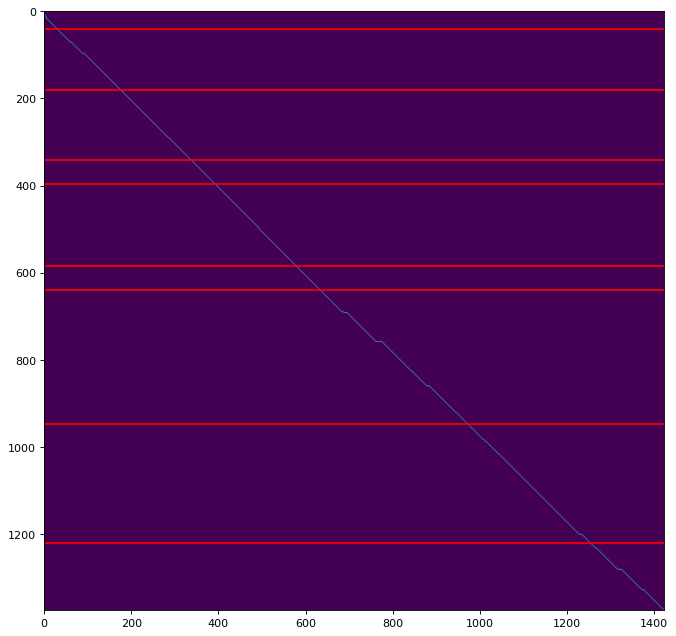

In [32]:
gen_audio_starts = [0]

for mfcc in generated_mfcc[:-1]:
    start_pos = gen_audio_starts[-1] + mfcc.shape[1]
    gen_audio_starts.append(start_pos)


plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(path_draw)
for start_x in gen_audio_starts:
    plt.axhline(y=start_x, c="red")
plt.show()

In [33]:
gen_audio_starts

[0, 40, 181, 342, 397, 585, 640, 947, 1220]

Let's match a points from concated mfcc to th input.

In [34]:
original_audio_starts = []
ptr = 0

_path = path[::-1]

for p in _path:
    if ptr == len(gen_audio_starts):
        break

    if p[0] == gen_audio_starts[ptr]:
        original_audio_starts.append(p[1])
        ptr += 1

In [35]:
original_audio_starts

[0, 27, 174, 336, 391, 577, 632, 971, 1253]

In [36]:
print("translation timestamps from A to B")
for i, j in zip(gen_audio_starts, original_audio_starts):
    print(i, "->", j)

translation timestamps from A to B
0 -> 0
40 -> 27
181 -> 174
342 -> 336
397 -> 391
585 -> 577
640 -> 632
947 -> 971
1220 -> 1253


Now we can transform in-MFCC timestamps into in-audio timestamps using the ratio between aduio and mfcc.
And get the segments starts and ends for every sentence.

In [37]:
segments = list(zip(original_audio_starts, original_audio_starts[1:] + [original_mfcc.shape[1]]))
print(segments)

[(0, 27), (27, 174), (174, 336), (336, 391), (391, 577), (577, 632), (632, 971), (971, 1253), (1253, 1423)]


In [38]:
ratio = original_audio.shape[0] / original_mfcc.shape[1]

In [39]:
original_audio.shape[0], original_mfcc.shape[1]

(728312, 1423)

In [40]:
ratio

511.8144764581869

Lets compare sentecnes and audio segments

In [41]:
for segment, sentence in zip(segments, sentences):
    start_frame = int(segment[0] * ratio)
    end_frame = int(segment[1] * ratio)

    audio_segment = original_audio[start_frame:end_frame]

    print(sentence)
    IPython.display.display(Audio(data=audio_segment, rate=22050))

the ladies.


on this adventure he was about the business of young robin rue.


they give him the flower from the hair of the emperor's daughter, and sing-.


the wandering singer.


but if time is still to spare, the second part of the game is played like this.


the emperor's daughter.


the singer then drops a second flower into the lap of the child in the middle, and goes away, and this ends the first part of the game.


the emperor's daughter is not yet released, for the key of her tower is understood to be still in the keeping of the dancing children.


forgotten, too, the name of gillian, the lovely captive.
